# 开发 AI 应用

未来，AI 算法在日常生活中的应用将越来越广泛。例如，你可能想要在智能手机应用中包含图像分类器。为此，在整个应用架构中，你将使用一个用成百上千个图像训练过的深度学习模型。未来的软件开发很大一部分将是使用这些模型作为应用的常用部分。

在此项目中，你将训练一个图像分类器来识别不同的花卉品种。可以想象有这么一款手机应用，当你对着花卉拍摄时，它能够告诉你这朵花的名称。在实际操作中，你会训练此分类器，然后导出它以用在你的应用中。我们将使用[此数据集](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)，其中包含 102 个花卉类别。你可以在下面查看几个示例。 

<img src='assets/Flowers.png' width=500px>

该项目分为多个步骤：

* 加载和预处理图像数据集
* 用数据集训练图像分类器
* 使用训练的分类器预测图像内容

我们将指导你完成每一步，你将用 Python 实现这些步骤。

完成此项目后，你将拥有一个可以用任何带标签图像的数据集进行训练的应用。你的网络将学习花卉，并成为一个命令行应用。但是，你对新技能的应用取决于你的想象力和构建数据集的精力。例如，想象有一款应用能够拍摄汽车，告诉你汽车的制造商和型号，然后查询关于该汽车的信息。构建你自己的数据集并开发一款新型应用吧。

首先，导入你所需的软件包。建议在代码开头导入所有软件包。当你创建此 notebook 时，如果发现你需要导入某个软件包，确保在开头导入该软件包。

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time
import json
import torch
import torch.nn.functional as F
import numpy as no
import matplotlib.pyplot as plt

from torch import nn,optim
from collections import OrderedDict
from torch.autograd import Variable
from torchvision import datasets,transforms,models
from PIL import Image

## 加载数据

在此项目中，你将使用 `torchvision` 加载数据（[文档](http://pytorch.org/docs/master/torchvision/transforms.html#)）。数据应该和此 notebook 一起包含在内，否则你可以[在此处下载数据](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)。数据集分成了三部分：训练集、验证集和测试集。对于训练集，你需要变换数据，例如随机缩放、剪裁和翻转。这样有助于网络泛化，并带来更好的效果。你还需要确保将输入数据的大小调整为 224x224 像素，因为预训练的网络需要这么做。

验证集和测试集用于衡量模型对尚未见过的数据的预测效果。对此步骤，你不需要进行任何缩放或旋转变换，但是需要将图像剪裁到合适的大小。

对于所有三个数据集，你都需要将均值和标准差标准化到网络期望的结果。均值为 `[0.485, 0.456, 0.406]`，标准差为 `[0.229, 0.224, 0.225]`。这样使得每个颜色通道的值位于 -1 到 1 之间，而不是 0 到 1 之间。

In [2]:
train_dir = 'flowers/train'
valid_dir = 'flowers/valid'
test_dir = 'flowers/test'""

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                                            [0.229,0.224,0.225])])

valid_transforms = transforms.Compose([transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                                            [0.229,0.224,0.225])])

test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])])

# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir,transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir,transform=valid_transforms)
test_dataset = datasets.ImageFolder(test_dir,transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True)

### 标签映射

你还需要加载从类别标签到类别名称的映射。你可以在文件 `cat_to_name.json` 中找到此映射。它是一个 JSON 对象，可以使用 [`json` 模块](https://docs.python.org/2/library/json.html)读取它。这样可以获得一个从整数编码的类别到实际花卉名称的映射字典。

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# 构建和训练分类器

数据准备好后，就开始构建和训练分类器了。和往常一样，你应该使用 `torchvision.models` 中的某个预训练模型获取图像特征。使用这些特征构建和训练新的前馈分类器。

这部分将由你来完成。如果你想与他人讨论这部分，欢迎与你的同学讨论！你还可以在论坛上提问或在工作时间内咨询我们的课程经理和助教导师。

请参阅[审阅标准](https://review.udacity.com/#!/rubrics/1663/view)，了解如何成功地完成此部分。你需要执行以下操作：

* 加载[预训练的网络](http://pytorch.org/docs/master/torchvision/models.html)（如果你需要一个起点，推荐使用 VGG 网络，它简单易用）
* 使用 ReLU 激活函数和丢弃定义新的未训练前馈网络作为分类器
* 使用反向传播训练分类器层，并使用预训练的网络获取特征
* 跟踪验证集的损失和准确率，以确定最佳超参数

我们在下面为你留了一个空的单元格，但是你可以使用多个单元格。建议将问题拆分为更小的部分，并单独运行。检查确保每部分都达到预期效果，然后再完成下个部分。你可能会发现，当你实现每部分时，可能需要回去修改之前的代码，这很正常！

训练时，确保仅更新前馈网络的权重。如果一切构建正确的话，验证准确率应该能够超过 70%。确保尝试不同的超参数（学习速率、分类器中的单元、周期等），寻找最佳模型。保存这些超参数并用作项目下个部分的默认值。

In [5]:
# TODO: Build and train your network
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 90175170.47it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
                          ('fc1',nn.Linear(25088,4096)),
                          ('relu1',nn.ReLU()),
                          ('dropout1',nn.Dropout(p=0.5)),
                          ('fc2',nn.Linear(4096,1000)),
                          ('relu2',nn.ReLU()),
                          ('dropout2',nn.Dropout()),
                          ('fc3',nn.Linear(1000,102)),
                          ('output',nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

In [7]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(),lr=0.001)

In [8]:
# Implement the training function
def train(model, trainloader, validloader, criterion, optimizer, epochs = 3, 
          log_interval = 20, device = 'cuda'):
    steps = 0
    running_loss = 0
    model.train()
    model.to('cuda')
    for e in range(epochs):
        for images, labels in trainloader:
            steps += 1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % log_interval == 0: 
                # Make sure network is in eval mode for inference
                model.eval()
                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    valid_loss, valid_accuracy = validate(model, validloader, criterion)
                    print("Epoch: {}/{}.. ".format(e + 1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss / log_interval),
                          "Valid Loss: {:.3f}.. ".format(valid_loss / len(validloader)),
                          "Valid Accuracy: {:.3f}".format(valid_accuracy / len(validloader)))
                    running_loss = 0
                    running_accu = 0
                    # Make sure training is back on
                    model.train()

def validate(model, validloader, criterion, device = 'cuda'):
    loss = 0
    accuracy = 0
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        # Log loss and accuracy on validation data
        output = model.forward(images)
        loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return loss, accuracy


train(model,trainloader,validloader,criterion,optimizer)

Epoch: 1/3..  Training Loss: 5.271..  Valid Loss: 4.137..  Valid Accuracy: 0.091
Epoch: 1/3..  Training Loss: 3.871..  Valid Loss: 3.156..  Valid Accuracy: 0.334
Epoch: 1/3..  Training Loss: 3.155..  Valid Loss: 2.345..  Valid Accuracy: 0.434
Epoch: 1/3..  Training Loss: 2.610..  Valid Loss: 1.917..  Valid Accuracy: 0.522
Epoch: 1/3..  Training Loss: 2.370..  Valid Loss: 1.682..  Valid Accuracy: 0.581
Epoch: 2/3..  Training Loss: 1.997..  Valid Loss: 1.536..  Valid Accuracy: 0.624
Epoch: 2/3..  Training Loss: 1.855..  Valid Loss: 1.350..  Valid Accuracy: 0.631
Epoch: 2/3..  Training Loss: 1.732..  Valid Loss: 1.199..  Valid Accuracy: 0.675
Epoch: 2/3..  Training Loss: 1.698..  Valid Loss: 1.150..  Valid Accuracy: 0.694
Epoch: 2/3..  Training Loss: 1.728..  Valid Loss: 1.121..  Valid Accuracy: 0.706
Epoch: 3/3..  Training Loss: 1.524..  Valid Loss: 1.164..  Valid Accuracy: 0.704
Epoch: 3/3..  Training Loss: 1.434..  Valid Loss: 1.078..  Valid Accuracy: 0.721
Epoch: 3/3..  Training Loss:

## 测试网络

建议使用网络在训练或验证过程中从未见过的测试数据测试训练的网络。这样，可以很好地判断模型预测全新图像的效果。用网络预测测试图像，并测量准确率，就像验证过程一样。如果模型训练良好的话，你应该能够达到大约 70% 的准确率。

In [9]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %


## 保存检查点

训练好网络后，保存模型，以便稍后加载它并进行预测。你可能还需要保存其他内容，例如从类别到索引的映射，索引是从某个图像数据集中获取的：`image_datasets['train'].class_to_idx`。你可以将其作为属性附加到模型上，这样稍后推理会更轻松。

In [10]:
#注意，稍后你需要完全重新构建模型，以便用模型进行推理。确保在检查点中包含你所需的任何信息。如果你想加载模型并继续训练，则需要保存周期数量和优化器状态 `optimizer.state_dict`。你可能需要在下面的下个部分使用训练的模型，因此建议立即保存它。

# TODO: Save the checkpoint 
#model.state_dict().keys()
#optimizer.state_dict().keys()

model.class_to_idx = train_dataset.class_to_idx
checkpoint = {'arch': 'vgg16_bn',
              'class_to_idx': model.class_to_idx,
              'input_size': 25088,
              'output_size': 102,
              'hidden_units': 4096,
              'epochs': 3,
              'log_interval': 32,
              'learning_rate': 0.001,
              'classifier': classifier,
              'optimizer_state_dict': optimizer.state_dict(),
              'model_state_dict': model.state_dict()}

torch.save(checkpoint,'checkpoint.pth')

## 加载检查点

此刻，建议写一个可以加载检查点并重新构建模型的函数。这样的话，你可以回到此项目并继续完善它，而不用重新训练网络。

In [11]:
def load_checkpoint(filepath):
    checkpoint= torch.load(filepath)
    model = models.vgg16(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = train_dataset.class_to_idx
    return model

首先，你需要处理输入图像，使其可以用于你的网络。

## 图像处理

你需要使用 `PIL` 加载图像（[文档](https://pillow.readthedocs.io/en/latest/reference/Image.html)）。建议写一个函数来处理图像，使图像可以作为模型的输入。该函数应该按照训练的相同方式处理图像。

首先，调整图像大小，使最小的边为 256 像素，并保持宽高比。为此，可以使用 [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 或 [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 方法。然后，你需要从图像的中心裁剪出 224x224 的部分。

图像的颜色通道通常编码为整数 0-255，但是该模型要求值为浮点数 0-1。你需要变换值。使用 Numpy 数组最简单，你可以从 PIL 图像中获取，例如 `np_image = np.array(pil_image)`。

和之前一样，网络要求图像按照特定的方式标准化。均值应标准化为 `[0.485, 0.456, 0.406]`，标准差应标准化为 `[0.229, 0.224, 0.225]`。你需要用每个颜色通道减去均值，然后除以标准差。

最后，PyTorch 要求颜色通道为第一个维度，但是在 PIL 图像和 Numpy 数组中是第三个维度。你可以使用 [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html)对维度重新排序。颜色通道必须是第一个维度，并保持另外两个维度的顺序。

In [12]:
def process_image(image):
    pil_img = Image.open(image)
    # Determine which demension is smaller
    # and resize to 256 while preserving aspect   
    if pil_img.size[0] > pil_img.size[1]: 
        pil_img.thumbnail((256 + 1, 256)) 
    else:
        pil_img.thumbnail((256, 256 + 1))            
    # Define the boundary and crop it around the center
    left = (pil_img.width - 224) / 2
    bottom = (pil_img.height - 224) / 2
    right = left + 224
    top = bottom + 224
    pil_img = pil_img.crop((left, bottom, right, top))
    # Normalize the img with np
    np_img = np.array(pil_img)
    np_img = np_img / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np_img - mean) / std
    np_img = np_img.transpose((2, 0, 1)) 
    np_img = torch.FloatTensor(np_img)
    
    return np_img

要检查你的项目，可以使用以下函数来转换 PyTorch 张量并将其显示在  notebook 中。如果 `process_image` 函数可行，用该函数运行输出应该会返回原始图像（但是剪裁掉的部分除外）。

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## 类别预测

可以获得格式正确的图像后 

要获得前 $K$ 个值，在张量中使用 [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk)。该函数会返回前 `k` 个概率和对应的类别索引。你需要使用  `class_to_idx`（希望你将其添加到了模型中）将这些索引转换为实际类别标签，或者从用来加载数据的[ `ImageFolder`](https://pytorch.org/docs/master/torchvision/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)进行转换。确保颠倒字典

同样，此方法应该接受图像路径和模型检查点，并返回概率和类别。

In [14]:
def predict(image_path, model, topk, gpu_mode):
    '''
    Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Process the img                                                                                                                                                                                     
    img = process_image(image_path)
    if gpu_mode:
        model.cuda()
        img = img.cuda()
    # Make sure model in evaluation mode                                                                                                                                                                  
    model.eval()
    # Feed forward to get the prediction                                                                                                                                                                  
    with torch.no_grad():
        outputs = model.forward(img.unsqueeze(0))
    # Calc probabilities and classes                                                                                                                                                                      
    probs, class_indices = outputs.topk(topk)
    probs = probs.exp().cpu().numpy()[0]
    class_indices = class_indices.cpu().numpy()[0]
    # Convert indices to classes                                                                                                                                                                          
    idx_to_class = {x: y for y, x in model.class_to_idx.items()}
    classes = [idx_to_class[i] for i in class_indices]
      
    return probs, classes

## 检查运行状况

你已经可以使用训练的模型做出预测，现在检查模型的性能如何。即使测试准确率很高，始终有必要检查是否存在明显的错误。使用 `matplotlib` 将前 5 个类别的概率以及输入图像绘制为条形图，应该如下所示：

<img src='assets/inference_example.png' width=300px>

你可以使用 `cat_to_name.json` 文件（应该之前已经在 notebook 中加载该文件）将类别整数编码转换为实际花卉名称。要将 PyTorch 张量显示为图像，请使用定义如下的 `imshow` 函数。

[ 0.61915654  0.08083386  0.06960377  0.05005452  0.04164048]
['65', '56', '62', '34', '46']


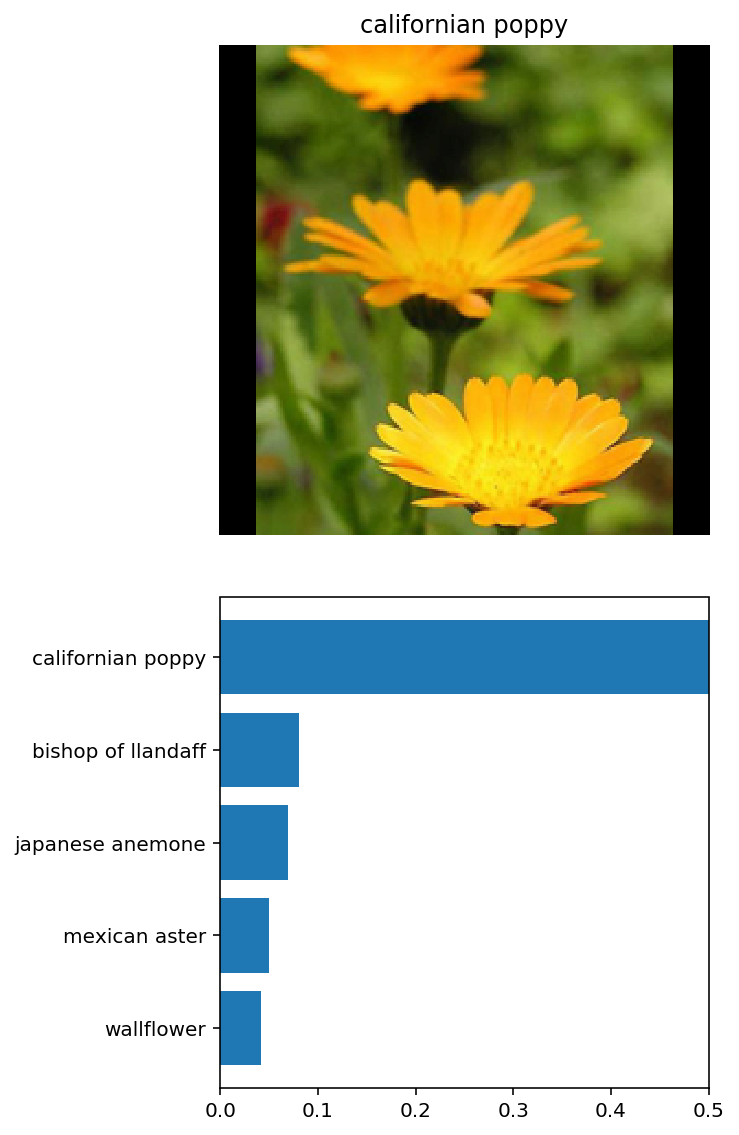

In [15]:
image_path = 'flowers/test/5/image_05169.jpg'
probs, classes = predict(image_path, model, 5, True)
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), nrows=2)
# PyTorch tensors assume the color channel is the first dimension
# but matplotlib assumes is the third dimension
image = process_image(image_path)
image = image.numpy().transpose((1, 2, 0))
# Undo preprocessing
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
# Image needs to be clipped between 0 and 1 or it looks like noise when displayed
image = np.clip(image, 0, 1)
ax1.axis('off')
top_class = classes[np.argmax(probs)]
ax1.set_title(cat_to_name[top_class])
ax1.imshow(image)
# Plot the bar chart
labels = [cat_to_name[cat] for cat in classes]
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlim(0, 0.5)
ax2.invert_yaxis() 
ax2.barh(y_pos, probs)
ax2.set_aspect(0.095)
plt.tight_layout()
print(probs)
print(classes)